In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.model_selection import train_test_split
import numpy
import pandas as pd
import datetime

In [2]:
data_dir = Path("./data_dir")

In [3]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#data = ImageDataBunch.from_csv(data_dir, folder='train', size=500, suffix='.jpeg', label_delim = ' ', ds_tfms=planet_tfms)

In [4]:
data = (ImageList.from_folder(data_dir) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=32)
        .normalize(imagenet_stats))  

In [5]:
data.classes

['Gut', 'Mittel', 'Schlecht', 'Sehr_Gut']

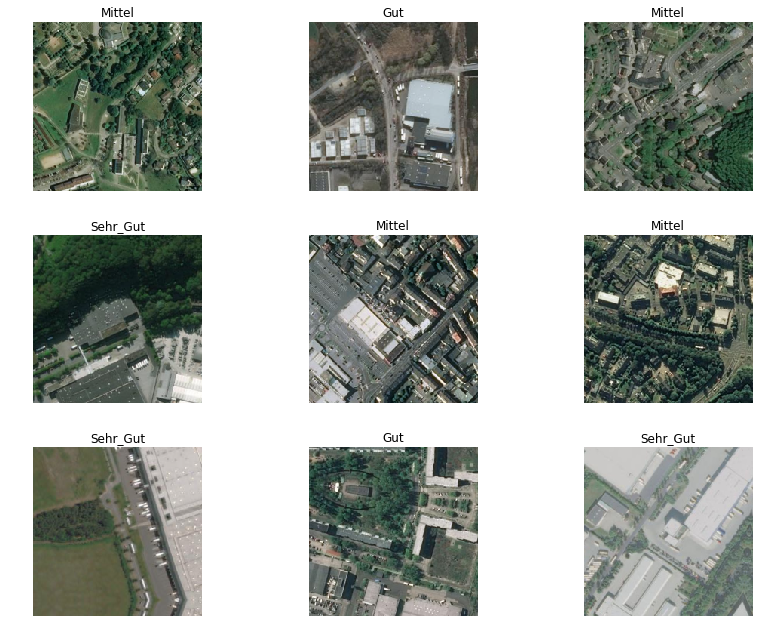

In [6]:
data.show_batch(rows=3, figsize=(12,9))

In [7]:
# set up convolutional neural network (cnn) based on pre-trained resnet50 architecture
# use accuracy as metric since we are doing classification tasks on single classes
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [8]:
# inspect network architecture
learn

Learner(data=ImageDataBunch;

Train: LabelList (89 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Sehr_Gut,Sehr_Gut,Sehr_Gut,Sehr_Gut,Sehr_Gut
Path: data_dir;

Valid: LabelList (23 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Sehr_Gut,Sehr_Gut,Sehr_Gut,Schlecht,Schlecht
Path: data_dir;

Test: LabelList (28 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data_dir, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bo

In [9]:
learn.fit_one_cycle(4) # run one cycle for 4 epochs using our determined learning rate to adjust output layer to our own data

epoch,train_loss,valid_loss,error_rate,time
0,1.878228,1.679863,0.826087,00:06
1,1.464806,2.543973,0.782609,00:01
2,1.308573,2.430670,0.695652,00:01
3,1.245958,2.114159,0.695652,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


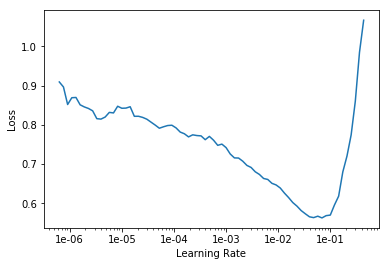

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.unfreeze() # must be done before calling lr_find --> we can now train all layers, not just the last one
learn.fit_one_cycle(4, max_lr=slice(1e-04, 1e-02)) # fit model again, now adjusting all layers

epoch,train_loss,valid_loss,error_rate,time
0,0.987851,1.820382,0.695652,00:03
1,1.021246,2.058197,0.521739,00:02
2,1.058480,2.803282,0.565217,00:02
3,0.998312,2.726085,0.608696,00:02


In [12]:
train_val_size = str(len(learn.data.train_ds + learn.data.valid_ds))
learn.save("model_" + str(datetime.datetime.now()) + "_" + train_val_size + "items")

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

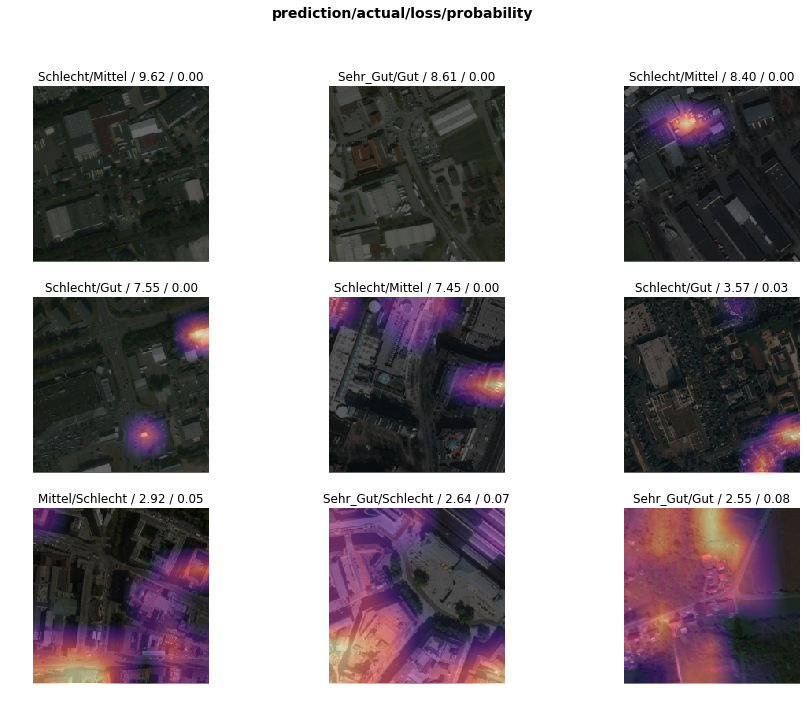

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

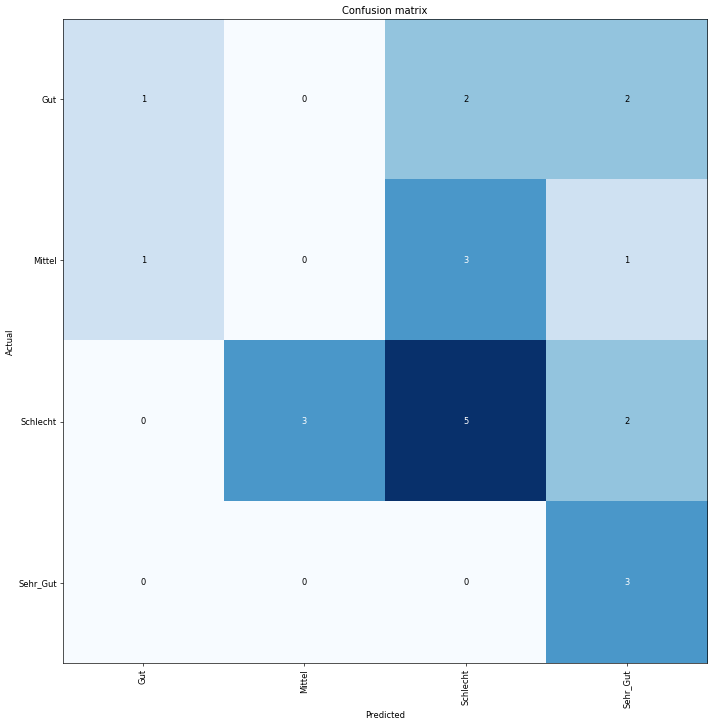

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=3)

[('Mittel', 'Schlecht', 3), ('Schlecht', 'Mittel', 3)]

In [18]:
#learn.export()

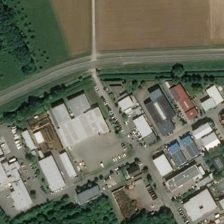

In [19]:
learn.data.test_ds[7][0]

In [20]:
prediction = learn.predict(learn.data.test_ds[7][0])

In [21]:
from torch import topk

In [22]:
prob, label = topk(prediction[2],4)

In [23]:
prediction[0]

Category Sehr_Gut

In [24]:
# show mapping from labels to indices in our model
learn.data.c2i

{'Gut': 0, 'Mittel': 1, 'Schlecht': 2, 'Sehr_Gut': 3}

In [25]:
# reverse key/value pairs from "Gut": 0 to 0: "Gut" to later use in map function 
inv_map = {v: k for k, v in learn.data.c2i.items()}

In [26]:
labels = list(map(inv_map.get,label.data.tolist()))

In [27]:
dict(zip(labels, prob.data.tolist()))

{'Sehr_Gut': 0.9892443418502808,
 'Schlecht': 0.008896734565496445,
 'Gut': 0.0018581491895020008,
 'Mittel': 7.644993615940621e-07}

# SKLEARN

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
from random import shuffle

In [29]:
def load_data(directory, IMG_SIZE):
    train_data = []
    for root, dirs, files in os.walk(directory):
        path = root.split(os.sep)
        for img in files:
            label = os.path.basename(root)
            fpath = os.path.join(root, img)
            img = Image.open(fpath)
            img = img.convert('L')
            img = img.resize(IMG_SIZE, Image.ANTIALIAS)
            train_data.append([np.array(img), label])

    shuffle(train_data)
    return train_data

In [30]:
def augment_data(data):
    aug_data = []
    for img in data:
        # Basic Data Augmentation - Horizontal Flipping
        flip_img = Image.fromarray(img[0])
        flip_img = flip_img.convert('L')
        flip_img = np.array(flip_img)
        flip_img = np.fliplr(flip_img)
        aug_data.append([flip_img, img[1]])
        
        # Vertical Flipping
        flip_img = Image.fromarray(img[0])
        flip_img = flip_img.convert('L')
        flip_img = np.array(flip_img)
        flip_img = np.flipud(flip_img)
        aug_data.append([flip_img, img[1]])
    return data + aug_data

In [31]:
def reshapeImage(img):
    nx, ny = img.shape
    return img.reshape((1, nx*ny))

In [32]:
IMG_SIZE = (224,224)
train = load_data(data_dir/"train", IMG_SIZE)
test = load_data(data_dir/"test", IMG_SIZE)

In [33]:
train = augment_data(train)

In [34]:
def formatDataset(data):
    images = []
    labels = []
    for elem in data:
        images.append(elem[0])
        labels.append(elem[1])
    
    images = np.array(images)
    nsamples, nx, ny = images.shape
    images = images.reshape((nsamples, nx*ny))
    return images, labels

In [35]:
train_data, train_labels = formatDataset(train)

In [36]:
train_data = normalize(train_data)

Gut


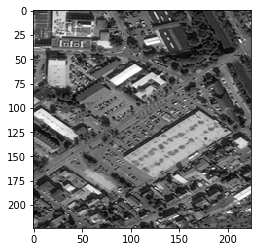

In [37]:
plt.imshow(train_data[10].reshape(IMG_SIZE), cmap = 'gist_gray')
print(train_labels[10])

In [38]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [39]:
#tuning = svc_param_selection(train_data, train_labels, 5)
# values found: {'C': 10, 'gamma': 1}

In [40]:
tuning = {'C': 10, 'gamma': 1}

In [41]:
svm = SVC(gamma=tuning["gamma"], C=tuning["C"], kernel="rbf", decision_function_shape='ovo')

In [42]:
svm.fit(train_data, train_labels)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Mittel


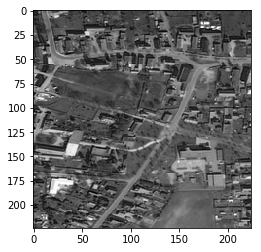

In [43]:
plt.imshow(train_data[8].reshape(tuple(reversed(IMG_SIZE))), cmap = 'gist_gray')
print(train_labels[8])

In [44]:
print(svm.predict(train_data[8].reshape(1,len(train_data[8]))), svm.decision_function(train_data[8].reshape(1,len(train_data[8]))))
print(svm.classes_)

['Mittel'] [[-0.999895  0.319976  0.068104  0.999807  0.99999  -0.344455]]
['Gut' 'Mittel' 'Schlecht' 'Sehr_Gut']


In [45]:
testImages = np.array([x[0] for x in test])
testLabels = [x[1] for x in test]

In [46]:
testImages = [reshapeImage(x) for x in testImages]

In [47]:
_,_, n = np.array(testImages).shape
testImages = np.array(testImages).reshape((28,n))

Schlecht


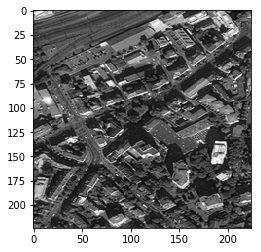

In [48]:
plt.imshow(testImages[2].reshape(IMG_SIZE), cmap = 'gist_gray')
print(testLabels[2])

In [49]:
svm.predict(testImages[2].reshape((1, len(testImages[2]))))

array(['Schlecht'], dtype='<U8')

In [50]:
dec = svm.decision_function([train_data[8]])
print(dec)
print(dec.shape[1]) # 4 classes: 4*3/2 = 6

svm.decision_function_shape = "ovr"
dec = svm.decision_function([train_data[2]])
dec.shape[1] # 4 classes


[[-0.999895  0.319976  0.068104  0.999807  0.99999  -0.344455]]
6


4

In [51]:
svm.predict(testImages)

array(['Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht',
       'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht',
       'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht', 'Schlecht',
       'Schlecht'], dtype='<U8')

In [52]:
matthews_corrcoef(testLabels, svm.predict(testImages))

/home/kunkler/.conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0